In [6]:
import os, sys, email
import numpy as np 
import pandas as pd
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')
#import plotly
#plotly.offline.init_notebook_mode()
#import plotly.graph_objs as go
import wordcloud

# Network analysis
import networkx as nx
# NLP
from nltk.tokenize.regexp import RegexpTokenizer

from subprocess import check_output
#print(check_output(["ls", "../emails"]).decode("utf8"))

In [8]:
emails_df = pd.read_csv('../enron/emails.csv')
print(emails_df.shape)
emails_df.head()

(517401, 2)


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [9]:
# A single message looks like this
print(emails_df['message'][0])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


In [10]:
## Helper functions
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [11]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True)
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]
# Parse content from emails
emails_df['content'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['To'] = emails_df['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del messages

In [12]:
emails_df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


In [13]:
print('shape of the dataframe:', emails_df.shape)
# Find number of unique values in each columns
for col in emails_df.columns:
    print(col, emails_df[col].nunique())

shape of the dataframe: (517401, 18)
file 517401
Message-ID 517401
Date 224128
From 20328
To 54748
Subject 159290
Mime-Version 1
Content-Type 2
Content-Transfer-Encoding 3
X-From 27980
X-To 73552
X-cc 33701
X-bcc 132
X-Folder 5335
X-Origin 259
X-FileName 429
content 249025
user 150


In [14]:
# Set index and drop columns with two few values
emails_df = emails_df.set_index('Message-ID')\
    .drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding'], axis=1)
# Parse datetime
emails_df['Date'] = pd.to_datetime(emails_df['Date'], infer_datetime_format=True)
emails_df.dtypes

Date          object
From          object
To            object
Subject       object
X-From        object
X-To          object
X-cc          object
X-bcc         object
X-Folder      object
X-Origin      object
X-FileName    object
content       object
user          object
dtype: object

In [22]:
ax = emails_df.groupby(emails_df['Date'].dt.strftime("%Y%m"))['content'].count().plot()
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)

AttributeError: Can only use .dt accessor with datetimelike values

In [23]:
ax = emails_df.groupby(emails_df['Date'].dt.dayofweek)['content'].count().plot()
ax.set_xlabel('Day of week', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)

AttributeError: Can only use .dt accessor with datetimelike values

In [24]:
ax = emails_df.groupby(emails_df['Date'].dt.hour)['content'].count().plot()
ax.set_xlabel('Hour', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)

AttributeError: Can only use .dt accessor with datetimelike values

In [25]:
# Count words in Subjects and content
tokenizer = RegexpTokenizer(r'(?u)\b\w\w+\b')
emails_df['subject_wc'] = emails_df['Subject'].map(lambda x: len(tokenizer.tokenize(x)))
emails_df['content_wc'] = emails_df['content'].map(lambda x: len(tokenizer.tokenize(x)))

In [27]:
grouped_by_people = emails_df.groupby('user').agg({
        'content': 'count', 
        'subject_wc': 'mean',
        'content_wc': 'mean',
    })
grouped_by_people.rename(columns={'content': 'N emails', 
                                  'subject_wc': 'Subject word count', 
                                  'content_wc': 'Content word count'}, inplace=True)
grouped_by_people.sort_values('N emails', ascending=False).head()

,N emails,Subject word count,Content word count
user,,,
kaminski-v,28465,4.217530,255.906025
dasovich-j,28234,5.237373,603.393391
kean-s,25351,4.959331,490.837561
mann-k,23381,4.211796,207.195501
jones-t,19950,4.748221,185.462607


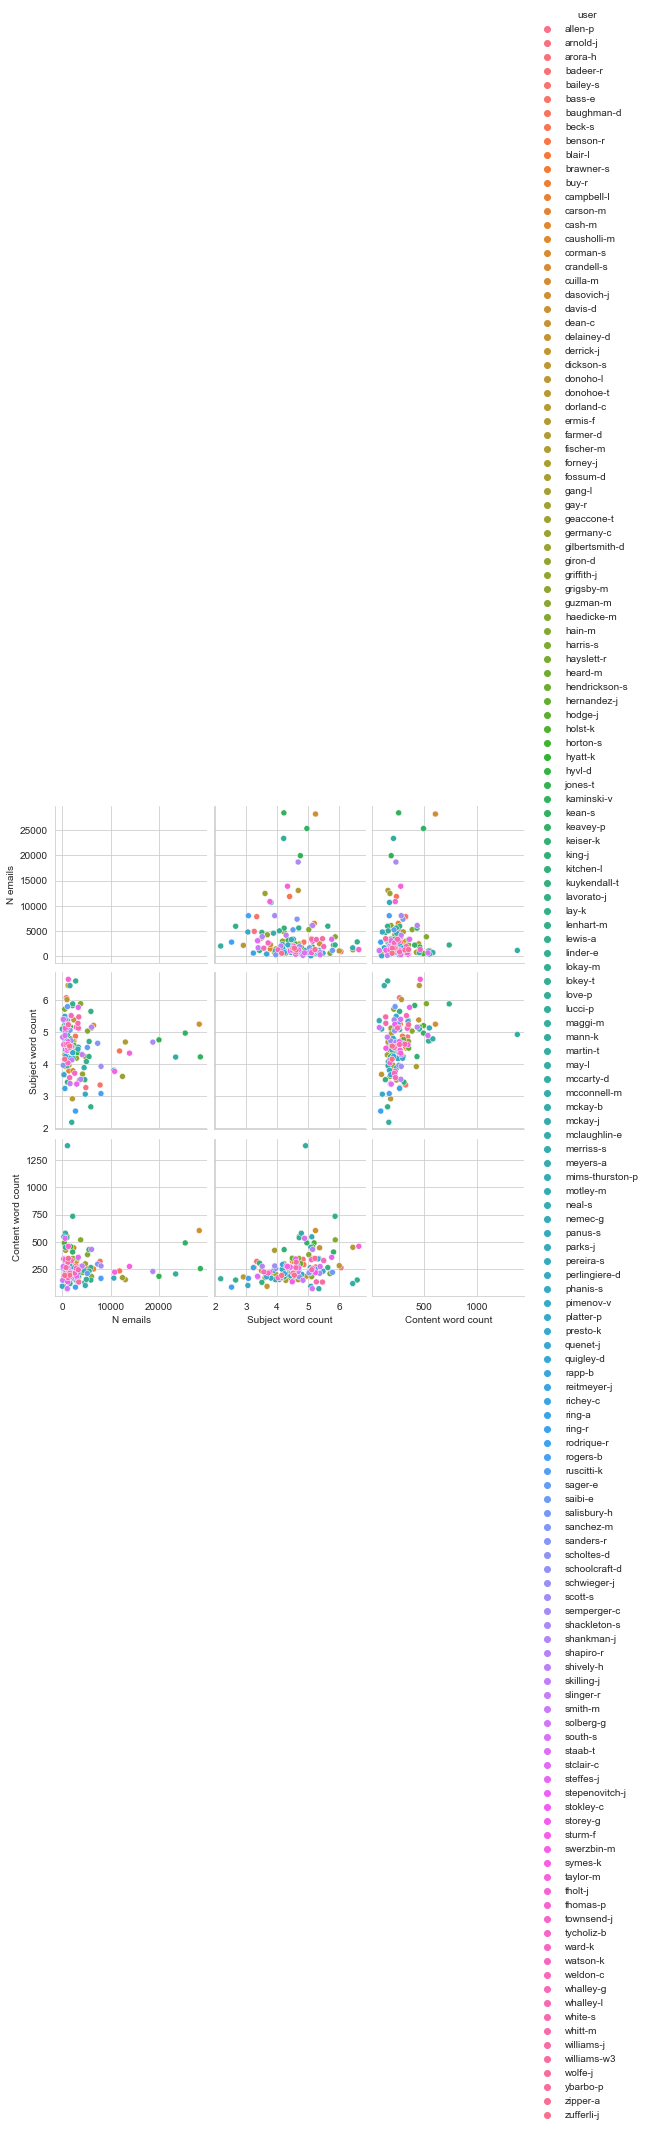

In [28]:
sns.pairplot(grouped_by_people.reset_index(), hue='user')

In [29]:
sub_df = emails_df[['From', 'To', 'Date']].dropna()
print(sub_df.shape)
# drop emails sending to multiple addresses
sub_df = sub_df.loc[sub_df['To'].map(len) == 1]
print(sub_df.shape)

(495554, 3)
(354600, 3)


In [38]:
sub_df = sub_df.groupby(['From', 'To']).count().reset_index()
# Unpack frozensets
sub_df['From'] = sub_df['From'].map(lambda x: next(iter(x)))
sub_df['To'] = sub_df['To'].map(lambda x: next(iter(x)))
# rename column
sub_df.rename(columns={'Date': 'count'}, inplace=True)
sub_df.sort_values('count', ascending=False).head(10)

,From,To,count
0,',s,1
579,p,e,1
555,o,h,1
556,o,i,1
557,o,j,1
558,o,k,1
559,o,l,1
560,o,m,1
561,o,n,1
562,o,o,1


C:\Users\Dell\anaconda3\envs\enron_env\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


(-0.5, 799.5, 599.5, -0.5)

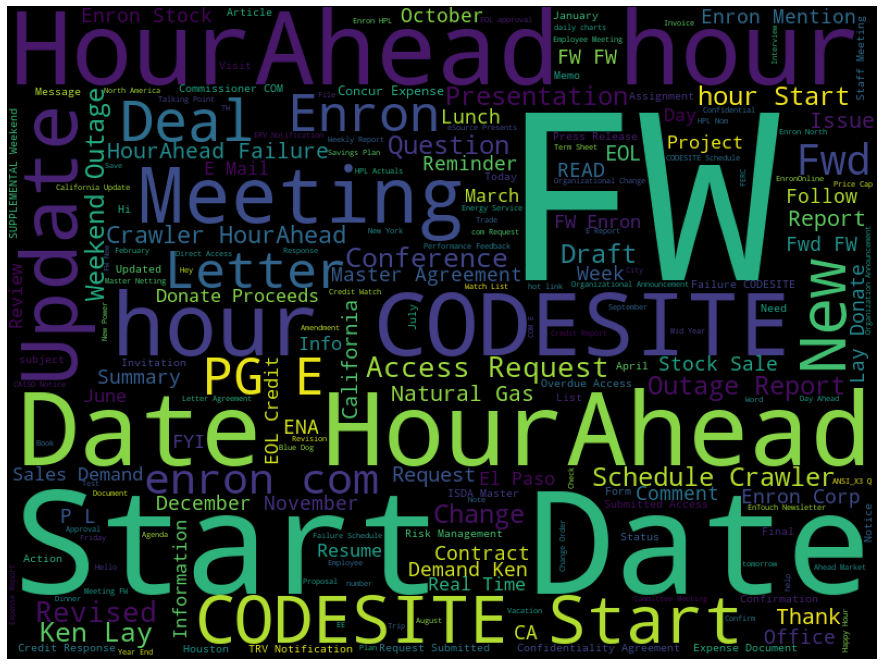

In [39]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

subjects = ' '.join(emails_df['Subject'])
fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=ENGLISH_STOP_WORDS).generate(subjects)
ax.imshow(wc)
ax.axis("off")

(-0.5, 799.5, 599.5, -0.5)

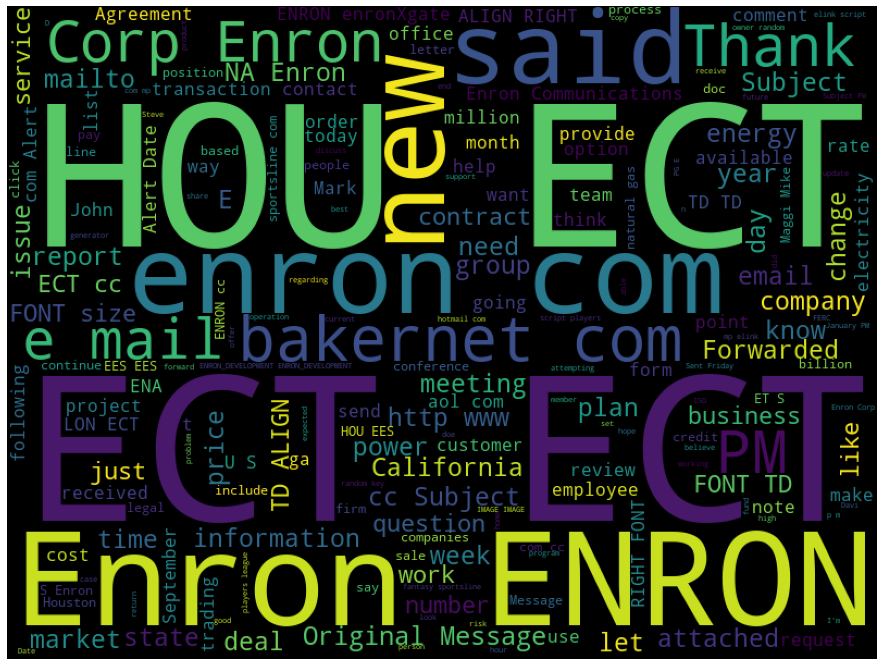

In [40]:
contents = ' '.join(emails_df.sample(1000)['content'])
fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=ENGLISH_STOP_WORDS).generate(contents)
ax.imshow(wc)
ax.axis("off")